# LSTM+Attention Model Training and SHAP computation using the Synthetic-events Dataset

**Author: Tesfagabir Meharizghi<br>Last Updated: 01/07/2021**

This notebook does the following actions:
- Model training using the given parameters
- Model selection using Intersection Similarity Score between ground truth helping features and predicted ones
    * Early stopping using Intersection similarity score criteria
- Computes SHAP values and visualizes for a few examples
- Visualizes the train/val/test probability scores from each trained model
- Visualizes the Intersection Similarity Scores for val/test splits
- Finally, after tweaking the parameters, it gets the best model for the given model architecture and dataset

Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- LSTM+Attention

Dataset:
- Synthetic-events (Toy Dataset)

Requirements:
- Make sure that you have already generated the synthetic toy dataset (train/val/test splits) using [Create_toy_dataset.ipynb](../../data/toy_dataset/Create_toy_dataset.ipynb).

Next Steps:
- Once you train different models, save the best one you found
- Do also the same for other models architectures (SimpleLSTM, XGB, etc.) using the separate notebooks
- Finally, go to [this ipynb]() to compare to compare the models' performances and shap values usig Jaccard Similarity Index

In [1]:
# pip install nb-black

In [2]:
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [3]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [4]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

import lstm_utils as l_utils
import att_lstm_models as lstm_att
import shap_jacc_utils as sj_utils

## LSTM+Attention Model Training

### Constants

In [5]:
nrows = 1e9
min_freq = 1

seq_len = 30

batch_size = 64  # For model training

n_epochs = 10
stop_num = 2

embedding_dim = 8
hidden_dim = 16
nlayers = 1
bidirectional = True
dropout = 0.3

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

# For model early stopping criteria
EARLY_STOPPING = "intersection_similarity"  # Values are any of these: ['intersection_similarity', 'loss']

# SHAP related constants
N_BACKGROUND = 500  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = True  # If negative examples are used as background
N_VALID_EXAMPLES = 32  # Number of validation examples to be used during model training
N_TEST_EXAMPLES = 64  # Number of test examples
TEST_POSITIVE_ONLY = True  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

train_data_path = "../../data/toy_dataset/data/{}/train.csv".format(seq_len)
valid_data_path = "../../data/toy_dataset/data/{}/val.csv".format(seq_len)
test_data_path = "../../data/toy_dataset/data/{}/test.csv".format(seq_len)

model_name = "lstm-att"
model_save_path = "./output/{}/{}/models/model_{}.pkl".format(seq_len, model_name, "{}")
shap_save_path = "./output/{}/{}/shap/{}_shap_{}.pkl".format(
    seq_len, model_name, "{}", "{}"
)  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

In [6]:
# LSTM+Attention Model Output Directory
model_save_dir = os.path.dirname(model_save_path)
shap_save_dir = os.path.dirname(shap_save_path)
if os.path.exists(model_save_dir):
    # Remove model save directory if exists
    shutil.rmtree(model_save_dir)
if os.path.exists(shap_save_dir):
    # Remove model save directory if exists
    shutil.rmtree(shap_save_dir)
os.makedirs(model_save_dir)
os.makedirs(shap_save_dir)
print(f"New directory created: {model_save_dir}")
print(f"New directory created: {shap_save_dir}")

print(f"Cuda available: {torch.cuda.is_available()}")
print("Total GPUs:", torch.cuda.device_count())
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

New directory created: ./output/30/lstm-att/models
New directory created: ./output/30/lstm-att/shap
Cuda available: True
Total GPUs: 4


### Create Vocab and Build Dataset

In [7]:
train_dataset, vocab = l_utils.build_lstm_dataset(
    train_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=None,
    nrows=nrows,
    rev=rev,
)
valid_dataset, _ = l_utils.build_lstm_dataset(
    valid_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

test_dataset, _ = l_utils.build_lstm_dataset(
    test_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

Building dataset from ../../data/toy_dataset/data/30/train.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/val.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/test.csv..
Success!


In [8]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

### Model Training

In [9]:
model = lstm_att.AttLSTM(
    embedding_dim, hidden_dim, vocab, model_device, nlayers=nlayers, dropout=dropout
)
model = model.cuda()

In [10]:
model

AttLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=64, out_features=1, bias=True)
  (attn_layer): Linear(in_features=32, out_features=1, bias=True)
  (dpt): Dropout(p=0.3, inplace=False)
  (context_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
print(
    "Computing the # of models params and check the accepted ratio of #params/#examples (accepted<=0.1)..."
)
# Get the number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_examples = 16000
ratio = float(total_params) / total_examples
passed = ratio <= 0.1
print(
    f"Total Model Params={total_params}, Total Examples={total_examples}, Ratio={ratio}, Test Passed={passed}"
)

Computing the # of models params and check the accepted ratio of #params/#examples (accepted<=0.1)...
Total Model Params=3715, Total Examples=16000, Ratio=0.2321875, Test Passed=False


In [12]:
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.9)

In [13]:
if EARLY_STOPPING == "intersection_similarity":
    best_valid = float("-inf")
else:
    best_valid = float("inf")
worse_valid = 0  # enable early stopping

for epoch in range(n_epochs):

    start_time = time.time()

    train_loss, train_auc = l_utils.epoch_train_lstm(
        model, train_dataloader, optimizer, loss_function
    )

    valid_loss, valid_auc = l_utils.epoch_val_lstm(
        model, valid_dataloader, loss_function
    )  # , return_preds=False

    val_shap_path = shap_save_path.format("val", f"{epoch:02}")
    if EARLY_STOPPING == "intersection_similarity":
        print(f"Computing SHAP Intersection Similarity for epoch={epoch}...")
        (features, scores, patients,) = sj_utils.get_lstm_features_and_shap_scores(
            model,
            train_dataloader,
            valid_dataloader,
            seq_len,
            val_shap_path,
            save_output=False,
            n_background=N_BACKGROUND,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            n_test=N_VALID_EXAMPLES,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
        )

        valid_sim, _ = sj_utils.get_model_intersection_similarity((features, scores))
    end_time = time.time()

    epoch_mins, epoch_secs = l_utils.epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

    if EARLY_STOPPING == "intersection_similarity":
        if valid_sim > best_valid:
            best_valid = valid_sim
            save_path = model_save_path.format(str(epoch).zfill(2))
            torch.save(model.state_dict(), save_path)
            sj_utils.save_pickle((features, scores, patients), val_shap_path)
            print("Saved Model and SHAP values, epoch {}".format(epoch))
            worse_valid = 0
        else:
            worse_valid += 1
            if worse_valid == stop_num:
                print("EARLY STOP ------")
                break
    else:
        if valid_loss < best_valid:
            best_valid = valid_loss
            save_path = model_save_path.format(str(epoch).zfill(2))
            torch.save(model.state_dict(), save_path)
            print("Saved Model, epoch {}".format(epoch))
            worse_valid = 0
        else:
            worse_valid += 1
            if worse_valid == stop_num:
                print("EARLY STOP ------")
                break

    scheduler.step()
    sim_message = ""
    if EARLY_STOPPING == "intersection_similarity":
        sim_message = f"| Val Int. Similarity: {valid_sim:.4f}"
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f} {sim_message}"
    )

Computing SHAP Intersection Similarity for epoch=0...
Epoch: 01 | Epoch Time: 2m 7s
saved ./output/30/lstm-att/shap/val_shap_00.pkl pickle..
Saved Model and SHAP values, epoch 0
Train Loss: 0.365 | Train AUC: 0.90 	 Val. Loss: 0.352 |  Val. AUC: 0.9045 | Val Int. Similarity: 0.2604
Computing SHAP Intersection Similarity for epoch=1...
Epoch: 02 | Epoch Time: 2m 7s
saved ./output/30/lstm-att/shap/val_shap_01.pkl pickle..
Saved Model and SHAP values, epoch 1
Train Loss: 0.358 | Train AUC: 0.90 	 Val. Loss: 0.322 |  Val. AUC: 0.9048 | Val Int. Similarity: 0.3594
Computing SHAP Intersection Similarity for epoch=2...
Epoch: 03 | Epoch Time: 2m 7s
saved ./output/30/lstm-att/shap/val_shap_02.pkl pickle..
Saved Model and SHAP values, epoch 2
Train Loss: 0.346 | Train AUC: 0.90 	 Val. Loss: 0.319 |  Val. AUC: 0.9078 | Val Int. Similarity: 0.5573
Computing SHAP Intersection Similarity for epoch=3...
Epoch: 04 | Epoch Time: 2m 8s
Train Loss: 0.344 | Train AUC: 0.90 	 Val. Loss: 0.322 |  Val. AUC:

In [14]:
# Get paths of each saved model
models_paths = sj_utils.get_model_paths(model_save_path)

## Model Validation and Visualization

Processing for model model_00.pkl ...
Loading the trained weights...
Computing the models performances for train/val/test splits...
Ploting Histograms of Train/Val/Test Predicted Scores...


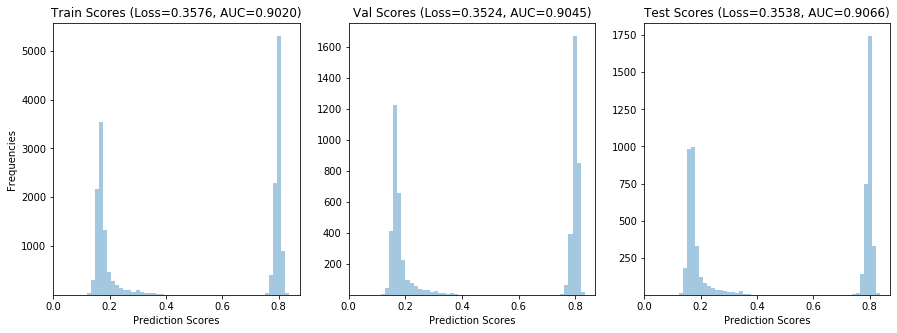

Computing SHAP for 32 positive val examples...


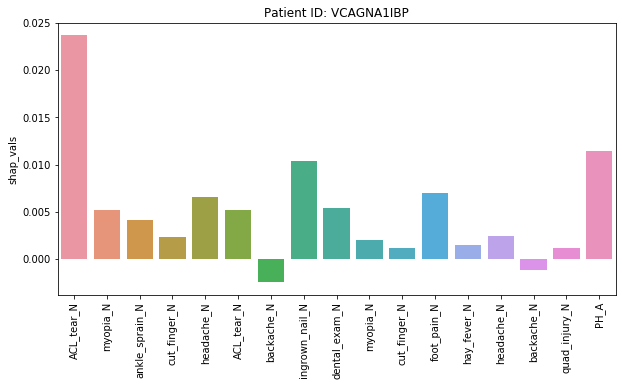

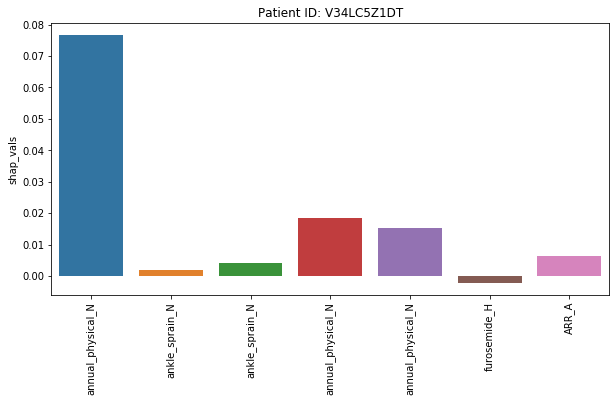

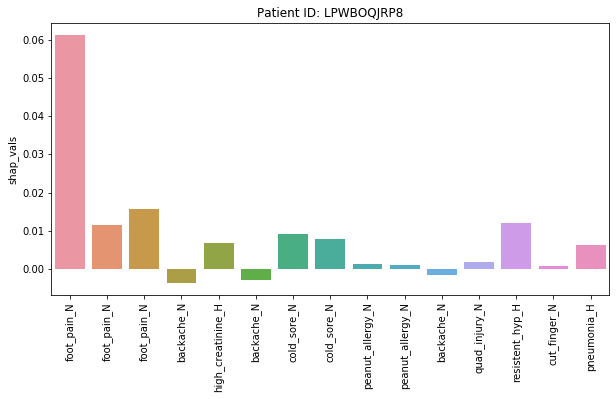

Computing Intersection Similarity...


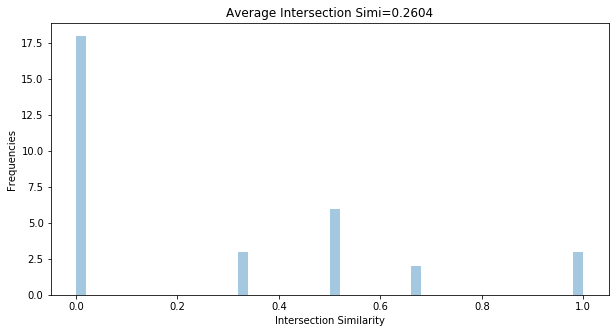

Processing for model model_01.pkl ...
Loading the trained weights...
Computing the models performances for train/val/test splits...
Ploting Histograms of Train/Val/Test Predicted Scores...


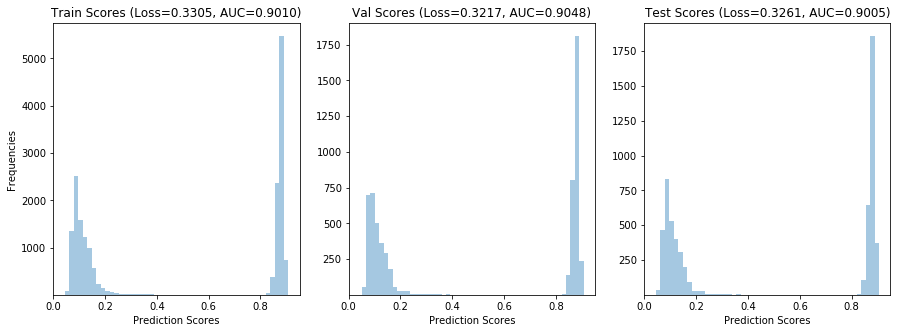

Computing SHAP for 32 positive val examples...


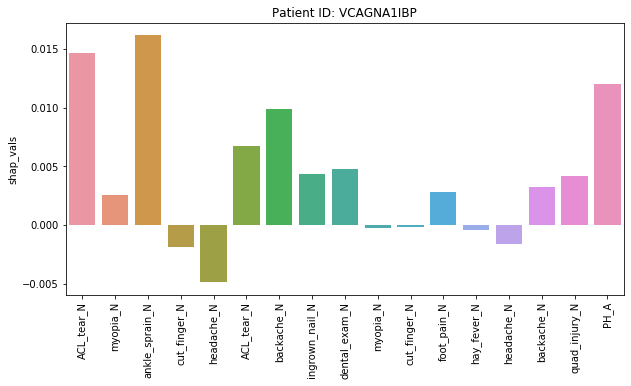

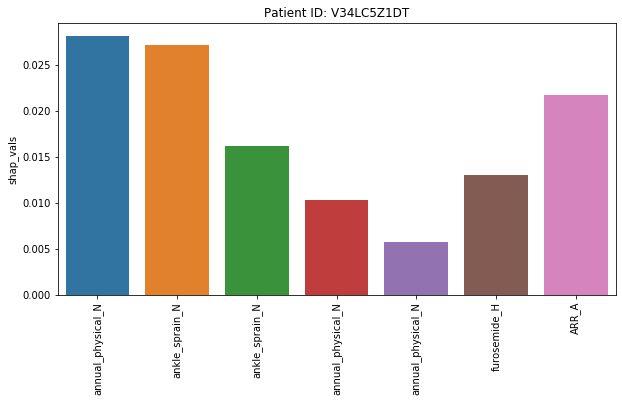

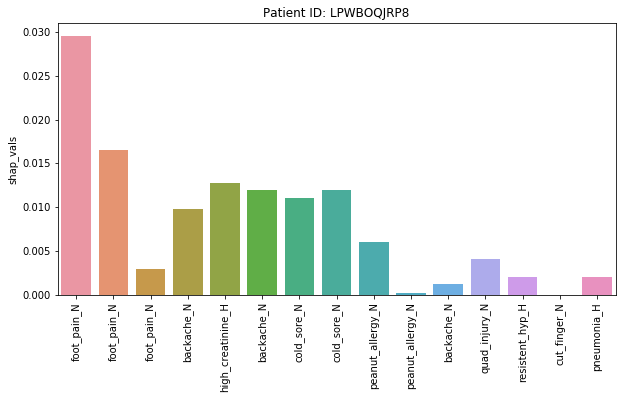

Computing Intersection Similarity...


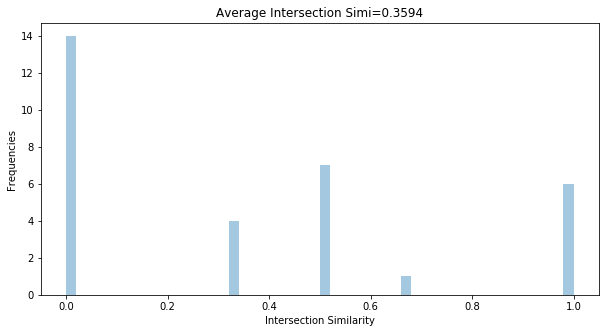

Processing for model model_02.pkl ...
Loading the trained weights...
Computing the models performances for train/val/test splits...
Ploting Histograms of Train/Val/Test Predicted Scores...


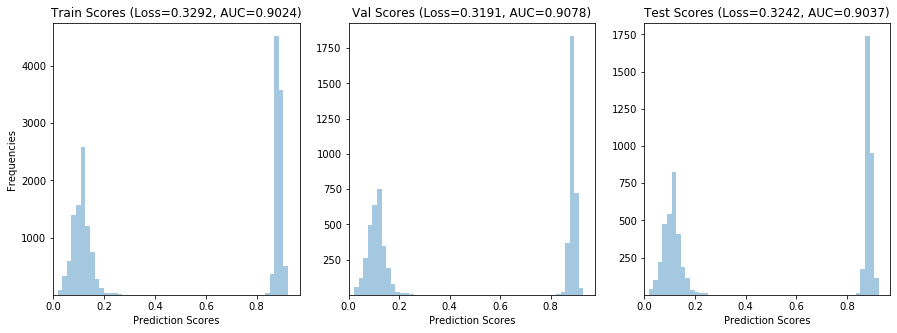

Computing SHAP for 32 positive val examples...


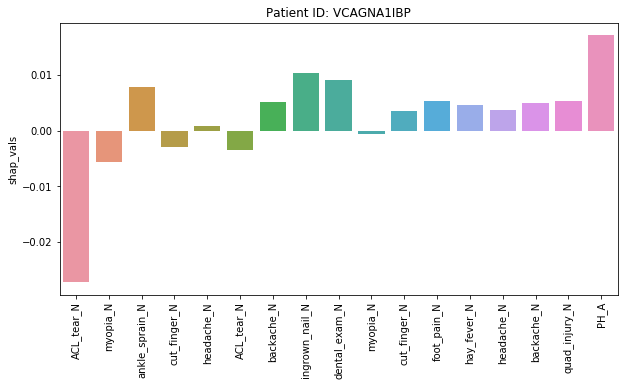

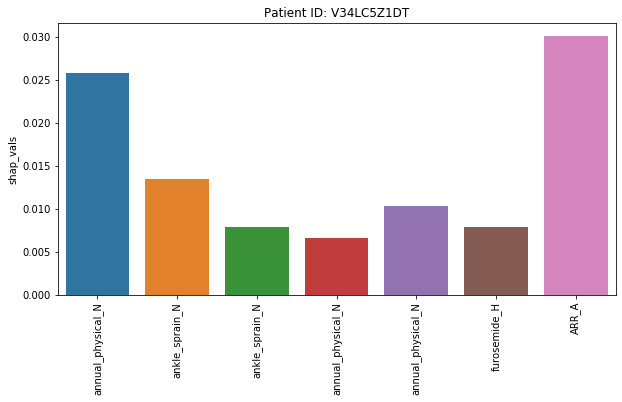

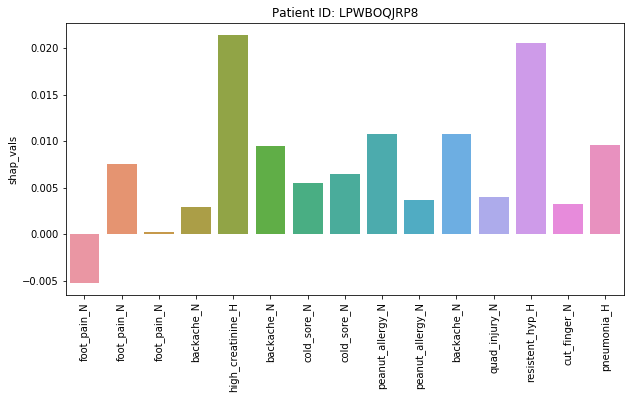

Computing Intersection Similarity...


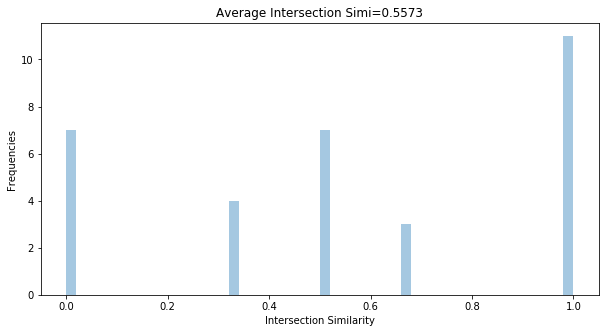

Computing SHAP for 64 positive TEST examples for the final model...
saved ./output/30/lstm-att/shap/test_shap_02.pkl pickle..


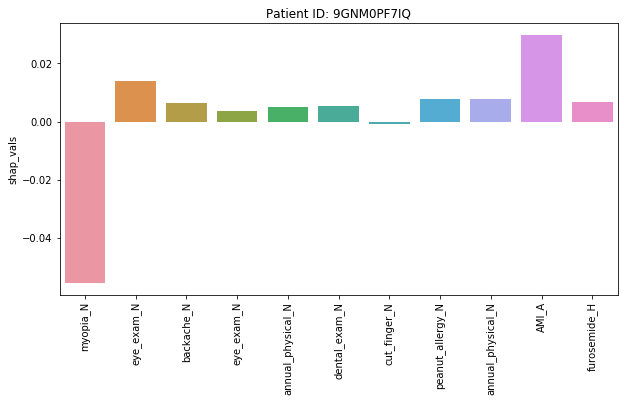

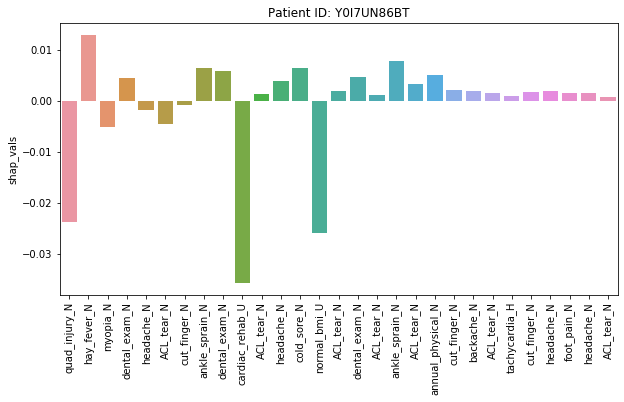

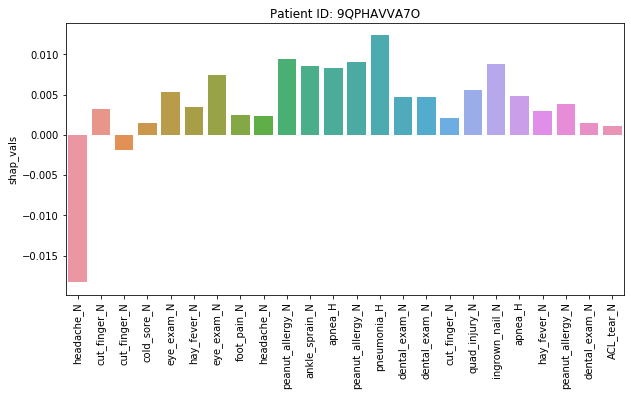

Computing Intersection Similarity...


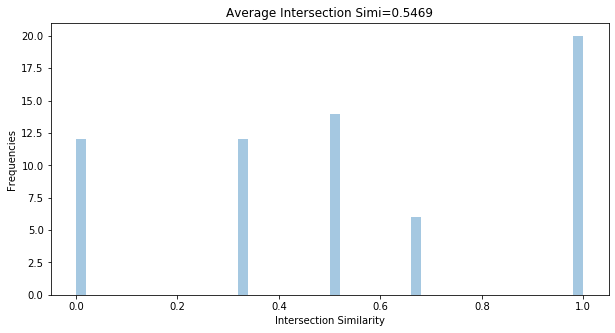

Finally computing and visualizing the global feature importance of the best model....


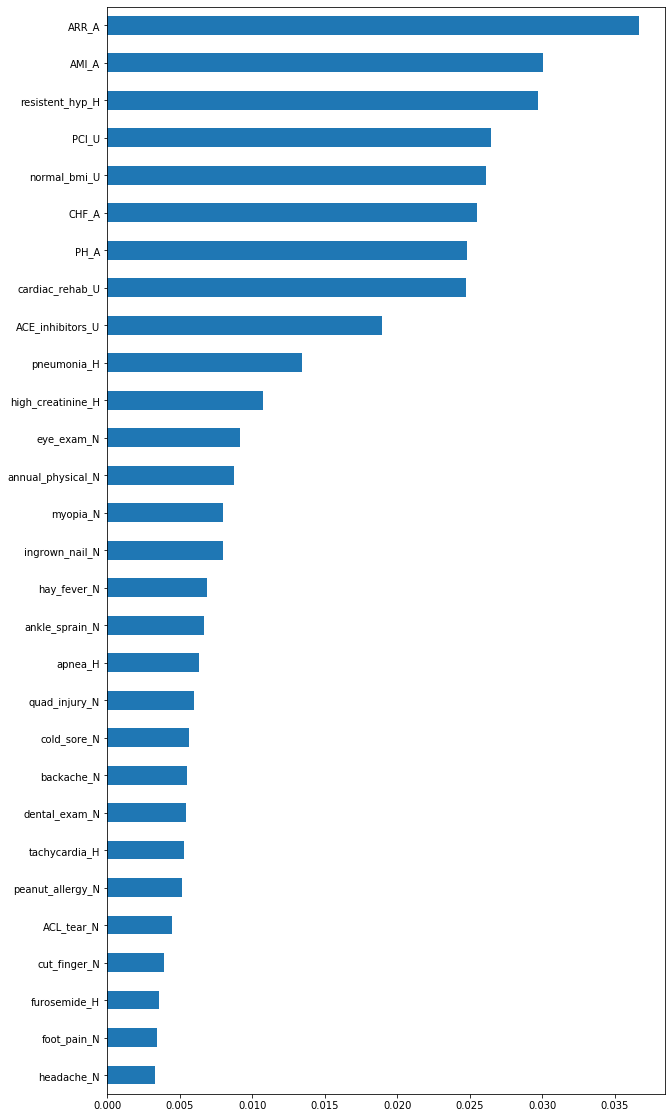

All tasks SUCCESSFULLY completed!


In [15]:
total_models = len(models_paths)
for i, model_path in enumerate(models_paths):
    print(f"Processing for model {os.path.basename(model_path)} ...")
    # Load trained weights
    print("Loading the trained weights...")
    model.load_state_dict(torch.load(model_path))
    ##Get Train/Val/Test Scores
    print("Computing the models performances for train/val/test splits...")
    train_loss, train_auc, train_labels, train_scores = l_utils.epoch_val_lstm(
        model, train_dataloader, loss_function, return_preds=True
    )
    val_loss, val_auc, val_labels, val_scores = l_utils.epoch_val_lstm(
        model, valid_dataloader, loss_function, return_preds=True
    )
    test_loss, test_auc, test_labels, test_scores = l_utils.epoch_val_lstm(
        model, test_dataloader, loss_function, return_preds=True
    )
    print("Ploting Histograms of Train/Val/Test Predicted Scores...")
    _, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 5))
    # Train
    scores = train_scores.flatten().tolist()
    axes = sj_utils.plot_histogram(
        scores,
        title=f"Train Scores (Loss={train_loss:.4f}, AUC={train_auc:.4f})",
        xlabel="Prediction Scores",
        ylabel="Frequencies",
        axes=axes,
        axes_idx=0,
    )
    # Val
    scores = val_scores.flatten().tolist()
    axes = sj_utils.plot_histogram(
        scores,
        title=f"Val Scores (Loss={val_loss:.4f}, AUC={val_auc:.4f})",
        xlabel="Prediction Scores",
        ylabel="",
        axes=axes,
        axes_idx=1,
    )
    # Test
    scores = test_scores.flatten().tolist()
    axes = sj_utils.plot_histogram(
        scores,
        title=f"Test Scores (Loss={test_loss:.4f}, AUC={test_auc:.4f})",
        xlabel="Prediction Scores",
        ylabel="",
        axes=axes,
        axes_idx=2,
    )
    plt.show()

    print(f"Computing SHAP for {N_VALID_EXAMPLES} positive val examples...")
    epoch = sj_utils.get_epoch_number_from_path(model_path)
    val_shap_path = shap_save_path.format("val", f"{epoch:02}")
    (
        features,
        scores,
        patients,
    ) = sj_utils.load_pickle(val_shap_path)

    for idx in range(N_VALID_EXAMPLES):
        if idx > 2:
            break
        features1 = features[idx]
        scores1 = scores[idx]
        patient_id = patients[idx]

        df_shap = pd.DataFrame(
            np.array([features1, scores1]).T, columns=["events", "shap_vals"]
        )
        df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

        sj_utils.plot_shap_values(
            df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
        )

    print("Computing Intersection Similarity...")
    avg_sim, sim = sj_utils.get_model_intersection_similarity((features, scores))
    sj_utils.plot_histogram(
        sim,
        title=f"Average Intersection Simi={avg_sim:.4f}",
        xlabel="Intersection Similarity",
        ylabel="Frequencies",
        axes=None,
    )

    # For the best model, get the final performance (test set) (intersection similarity)
    if i == (total_models - 1):
        print(
            f"Computing SHAP for {N_TEST_EXAMPLES} positive TEST examples for the final model..."
        )
        test_shap_path = shap_save_path.format("test", f"{epoch:02}")
        (features, scores, patients,) = sj_utils.get_lstm_features_and_shap_scores(
            model,
            train_dataloader,
            test_dataloader,
            seq_len,
            test_shap_path,
            save_output=True,
            n_background=N_BACKGROUND,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            n_test=N_TEST_EXAMPLES,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
        )

        for idx in range(N_TEST_EXAMPLES):
            if idx > 2:
                break
            features1 = features[idx]
            scores1 = scores[idx]
            patient_id = patients[idx]

            df_shap = pd.DataFrame(
                np.array([features1, scores1]).T,
                columns=["events", "shap_vals"],
            )
            df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

            sj_utils.plot_shap_values(
                df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
            )

        print("Computing Intersection Similarity...")
        avg_sim, sim = sj_utils.get_model_intersection_similarity((features, scores))
        sj_utils.plot_histogram(
            sim,
            title=f"Average Intersection Simi={avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )

        print(
            "Finally computing and visualizing the global feature importance of the best model...."
        )
        feat_importance = sj_utils.get_global_feature_importance(features, scores)
        sj_utils.plot_global_feature_importance(feat_importance)
        print("All tasks SUCCESSFULLY completed!")

    print("=" * 100)